# ParquetDB with the Jarvis Dataset DFT_3D

This tutorial demonstrates how to use the **ParquetDB** package to create, manage, and query a dataset from the Jarvis project (specifically the `dft_3d` dataset). We'll cover:

- Downloading and unzipping the dataset
- Loading and cleaning the dataset using Pandas
- Creating a ParquetDB database
- Inspecting the database schema
- Performing a full table read
- Reading the data in batches

Let's get started!

In [ ]:
!pip install jarvis-tools

In [1]:
import os
import json
import time
import zipfile
import pandas as pd
import pyarrow as pa
from glob import glob

# Import the ParquetDB package
from jarvis.db.figshare import data
from parquetdb import ParquetDB, config


# Change the data directory to the one you want to use
data_dir = config.data_dir

## Downloading the Jarvis Dataset

The following function downloads the Jarvis dataset and unzips any downloaded zip files. The dataset is stored in a specified directory.

In [2]:
def download_jarvis_dataset(dataset_name: str, store_dir: str):
    os.makedirs(store_dir, exist_ok=True)
    
    # Download the dataset using your `data` function (ensure it is defined/imported)
    d = data(dataset_name, store_dir=store_dir)
    
    # Unzip any downloaded zip files
    zip_files = [f for f in os.listdir(store_dir) if f.endswith('.zip')]
    for zip_file in zip_files:
        with zipfile.ZipFile(os.path.join(store_dir, zip_file), 'r') as zip_ref:
            zip_ref.extractall(store_dir)
    return d

# Example usage (uncomment to run):
store_dir = os.path.join(data_dir, 'external', 'Jarvis', 'dft_3d')
download_jarvis_dataset('dft_3d', store_dir)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


[{'jid': 'JVASP-90856',
  'spg_number': '129',
  'spg_symbol': 'P4/nmm',
  'formula': 'TiCuSiAs',
  'formation_energy_peratom': -0.42762,
  'func': 'OptB88vdW',
  'optb88vdw_bandgap': 0.0,
  'atoms': {'lattice_mat': [[3.566933224304235, 0.0, -0.0],
    [0.0, 3.566933224304235, -0.0],
    [-0.0, -0.0, 9.397075454186664]],
   'coords': [[2.6751975000000003, 2.6751975000000003, 7.376101754328542],
    [0.8917325, 0.8917325, 2.0209782456714573],
    [0.8917325, 2.6751975000000003, 4.69854],
    [2.6751975000000003, 0.8917325, 4.69854],
    [0.8917325, 2.6751975000000003, 0.0],
    [2.6751975000000003, 0.8917325, 0.0],
    [2.6751975000000003, 2.6751975000000003, 2.8894795605846353],
    [0.8917325, 0.8917325, 6.507600439415366]],
   'elements': ['Ti', 'Ti', 'Cu', 'Cu', 'Si', 'Si', 'As', 'As'],
   'abc': [3.56693, 3.56693, 9.39708],
   'angles': [90.0, 90.0, 90.0],
   'cartesian': True,
   'props': ['', '', '', '', '', '', '', '']},
  'slme': 'na',
  'magmom_oszicar': 0.0,
  'spillage': 'na

## Loading and Cleaning the Dataset

Next, we load the dataset from a JSON file, convert it to a Pandas DataFrame, and perform some cleaning. Specifically, we replace any "na" strings with `None` so that the data is in a suitable format.

This cleaning is necessary for ParquetDB as when the data gets converted to pyarrow tables the typing on the values have to be consistent. In Jarvis, they specify missing values as a string "na", which has conflicts with the innate type of the property.

In [2]:
# Define the storage directory for the dataset
store_dir = os.path.join(config.data_dir, 'external', 'Jarvis', 'dft_3d')
os.makedirs(store_dir, exist_ok=True)

# Check if the dataset is already downloaded
json_files = glob(os.path.join(store_dir, '*.json'))
if len(json_files) == 0:
    print("No dataset found, downloading...")
    d = download_jarvis_dataset('dft_3d', store_dir)  # Download the dataset

print("Loading dataset...")
json_files = glob(os.path.join(store_dir, '*.json'))
with open(json_files[0], 'r') as f:
    d = json.load(f)

# Convert the dataset to a Pandas DataFrame
print("Converting to pandas DataFrame and cleaning dataset...")
df = pd.DataFrame(d)

# Replace "na" values with None
print("Replacing 'na' values with None...")
df = df.replace("na", None)

# Clean nested dictionaries in the 'effective_masses_300K' column
print("Cleaning 'effective_masses_300K' dictionaries...")
def clean_mass_dict(d):
    if isinstance(d, dict):
        return {k: None if v == 'na' else v for k, v in d.items()}
    return d

df['effective_masses_300K'] = df['effective_masses_300K'].apply(clean_mass_dict)

print("Data cleaning complete.")

Loading dataset...
Converting to pandas DataFrame and cleaning dataset...
Replacing 'na' values with None...
Cleaning 'effective_masses_300K' dictionaries...
Data cleaning complete.


## Creating the Parquet Database

Now we create a ParquetDB database using the cleaned DataFrame. If a database with the same dataset name already exists, we drop it and create a new one. After creation, we print the schema of the database.

In [3]:
print("Creating ParquetDB database...")
db_path = os.path.join(data_dir, 'external', 'Jarvis', 'dft_3d', "DFT3D")
db = ParquetDB(db_path=db_path)

db.create(df)

print("Database created successfully.")
print(db)
# Free up memory by deleting the DataFrame and dataset dictionary
del df
del d

Creating ParquetDB database...
Database created successfully.
PARQUETDB SUMMARY
Database path: Z:\data\parquetdb\data\external\Jarvis\dft_3d\DFT3D

• Number of columns: 72
• Number of rows: 75993
• Number of files: 1
• Number of rows per file: [75993]
• Number of row groups per file: [3]
• Serialized metadata size per file: [33100] Bytes

############################################################
METADATA
############################################################

############################################################
COLUMN DETAILS
############################################################
• Columns:
    - mepsz
    - Tc_supercon
    - max_ir_mode
    - poisson
    - dfpt_piezo_max_eij
    - epsy
    - typ
    - spg_number
    - pkappa
    - bulk_modulus_kv
    - atoms.props
    - formation_energy_peratom
    - mbj_bandgap
    - n-powerfact
    - search
    - dfpt_piezo_max_dielectric_electronic
    - encut
    - pcond
    - nat
    - nkappa
    - n-Seebeck
    - effective

In [4]:
file_sizes = db.get_file_sizes(verbose=True)
row_group_sizes_per_file = db.get_row_group_sizes_per_file(verbose=True)


DFT3D_0.parquet: 38.08940124511719 MB
File: DFT3D_0.parquet
     0: 29.752275466918945 MB
     1: 26.32348346710205 MB
     2: 6.722073554992676 MB


## Reading the Full Table

In this step, we perform a full table read from the database. We also monitor the memory allocated by PyArrow before and after reading the data.

In [5]:
print("\nFull Table Read Example")
time.sleep(0.5)
print(f"Total allocated bytes before reading: {pa.total_allocated_bytes() / 10**6:.2f} MB")

# Read the entire table with nested structures rebuilt
table = db.read(rebuild_nested_struct=True)
print(f"Total allocated bytes after reading: {pa.total_allocated_bytes() / 10**6:.2f} MB")

# Example: Access and display information from specific columns
atoms = table['atoms'].combine_chunks()
print(f"Length of 'atoms' column: {len(atoms)}")

elastic_tensor = table['elastic_tensor'].combine_chunks().to_numpy_ndarray()
print(f"Shape of 'elastic_tensor' column: {elastic_tensor.shape}")
print("First elastic tensor:")
print(elastic_tensor[0])

modes = table['modes'].combine_chunks().to_numpy_ndarray()
print(f"Shape of 'modes' column: {modes.shape}")
print("First mode:")
print(modes[0])

# Clean up memory
del table
del atoms
del elastic_tensor
del modes


Full Table Read Example
Total allocated bytes before reading: 0.00 MB
Total allocated bytes after reading: 133.17 MB
Length of 'atoms' column: 75993
Shape of 'elastic_tensor' column: (75993, 6, 6)
First elastic tensor:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Shape of 'modes' column: (75993, 9)
First mode:
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Reading Data in Batches

For larger datasets, it may be more efficient to process data in batches. The following example demonstrates how to read data in batches using a generator. In this case, we load only the `atoms` column in batches of 10,000 records.

In [6]:
print("\nBatching Example")
time.sleep(0.5)
print(f"Total allocated bytes before creating generator: {pa.total_allocated_bytes() / 10**6:.2f} MB")

generator = db.read(columns=['atoms'], load_format='batches', batch_size=10000, rebuild_nested_struct=True)
print(f"Total allocated bytes after creating generator: {pa.total_allocated_bytes() / 10**6:.2f} MB")

for i, record_batch in enumerate(generator):
    print(f"Processing batch {i}")
    # Optionally, convert the batch to a pandas DataFrame
    # df_batch = record_batch.to_pandas()
    print(f"Bytes allocated for batch {i}: {pa.total_allocated_bytes() / 10**6:.2f} MB")
    
    # Free memory for the current batch
    del record_batch


Batching Example
Total allocated bytes before creating generator: 0.00 MB
Total allocated bytes after creating generator: 0.07 MB
Processing batch 0
Bytes allocated for batch 0: 83.37 MB
Processing batch 1
Bytes allocated for batch 1: 81.21 MB
Processing batch 2
Bytes allocated for batch 2: 81.21 MB
Processing batch 3
Bytes allocated for batch 3: 81.34 MB
Processing batch 4
Bytes allocated for batch 4: 65.01 MB
Processing batch 5
Bytes allocated for batch 5: 65.01 MB
Processing batch 6
Bytes allocated for batch 6: 65.00 MB
Processing batch 7
Bytes allocated for batch 7: 65.01 MB
Processing batch 8
Bytes allocated for batch 8: 65.00 MB
Processing batch 9
Bytes allocated for batch 9: 60.49 MB


## Plotting the n-Seebeck of the dataset

(151986, 1)


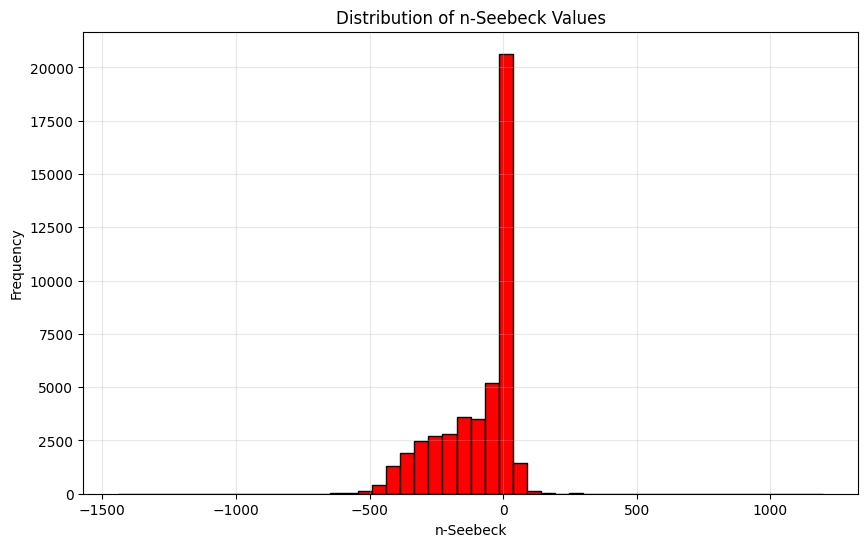

In [7]:
table = db.read(columns=['n-Seebeck'])
print(table.shape)


import matplotlib.pyplot as plt

# Convert to numpy array and remove any None/null values
seebeck_values = table['n-Seebeck'].to_numpy()
seebeck_values = seebeck_values[~pd.isnull(seebeck_values)]

plt.figure(figsize=(10, 6))
plt.hist(seebeck_values, bins=50, edgecolor='black')
plt.xlabel('n-Seebeck')
plt.ylabel('Frequency')
plt.title('Distribution of n-Seebeck Values')
plt.grid(True, alpha=0.3)
plt.show()

# Clean up memory
del table
del seebeck_values

## Conclusion

In this tutorial, we demonstrated how to use the **ParquetDB** package to:

- Download and extract a dataset
- Load and clean the data using Pandas
- Create a ParquetDB database and inspect its schema
- Read the data both in full and in batches

Feel free to modify and extend this tutorial to suit your data processing needs. 